### c)	Using the same Emotions Dataset for NLP from the Kaggle link in above question, now approach the problem using deep learning and transformer-based models. Perform the following steps:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string
import keras_tuner as kt
import tensorflow as tf

import warnings
warnings.simplefilter("always") 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow import keras
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification,DataCollatorWithPadding,create_optimizer
from kerastuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 1. & 2. Loading the Dataset and Cleaning the Dataset

In [6]:
df_train = pd.read_csv("Text Files/train.txt",delimiter=';', header=None, names=['text','emotion'])
df_val = pd.read_csv("Text Files/val.txt",delimiter=';', header=None, names=['text','emotion'])
df_test = pd.read_csv("Text Files/test.txt",delimiter=';', header=None, names=['text','emotion'])

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return ' '.join(lemmatized)

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_train[['text', 'clean_text','emotion']].head()

,text,clean_text,emotion
0,i didnt feel humiliated,didnt feel humili,sadness
1,i can go from feeling so hopeless to so damned...,go feel hopeless damn hope around someon care ...,sadness
2,im grabbing a minute to post i feel greedy wrong,im grab minut post feel greedi wrong,anger
3,i am ever feeling nostalgic about the fireplac...,ever feel nostalg fireplac know still properti,love
4,i am feeling grouchy,feel grouchi,anger


#### 3. Use DL models like Simple RNN, LSTM, GRU, Bidirectional RNN/LSTM/GRU, Stacked RNN/LSTM/GRU

In [7]:
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['emotion'])

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['clean_text'])
sequences = tokenizer.texts_to_sequences(df_train['clean_text'])
padded = pad_sequences(sequences, maxlen=50, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, df_train['label'], test_size=0.2, random_state=42)

# Build a BiLSTM model as example
model = Sequential([
    Embedding(10000, 64, input_length=50),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5


C:\Anacconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.3900 - loss: 1.4944 - val_accuracy: 0.7584 - val_loss: 0.7073
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.8392 - loss: 0.4699 - val_accuracy: 0.8650 - val_loss: 0.3999
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9424 - loss: 0.1825 - val_accuracy: 0.8712 - val_loss: 0.3778
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9646 - loss: 0.1077 - val_accuracy: 0.8587 - val_loss: 0.4668
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9718 - loss: 0.0798 - val_accuracy: 0.8725 - val_loss: 0.4628


#### 4. Use the KerasTuner to tune the parameters

In [8]:
import shutil
shutil.rmtree('tuner_dir/emotion_lstm', ignore_errors=True)

def build_model(hp):
    model = Sequential()
    model.add(Embedding(10000, hp.Int('embed_dim', 32, 128)))
    #model.add(Embedding(10000, hp.Int('embed_dim', 32, 128), input_length=50))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', 32, 128))))
    model.add(Dense(hp.Int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='emotion_lstm'
)

tuner.search(X_train, y_train, epochs=3, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 01m 38s]
val_accuracy: 0.860156238079071

Best val_accuracy So Far: 0.860156238079071
Total elapsed time: 00h 06m 20s


C:\Anacconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 5. Use Pretrained Transformer Models: BERT, DistilBERT, RoBERTa

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3

800/800 [==============================] - 4031s 5s/step - loss: 0.5562 - accuracy: 0.8077 - val_loss: 0.1893 - val_accuracy: 0.9256
Epoch 2/3
800/800 [==============================] - 3520s 4s/step - loss: 0.1537 - accuracy: 0.9377 - val_loss: 0.1531 - val_accuracy: 0.9306
Epoch 3/3
800/800 [==============================] - 3453s 4s/step - loss: 0.0981 - accuracy: 0.9548 - val_loss: 0.1605 - val_accuracy: 0.9325


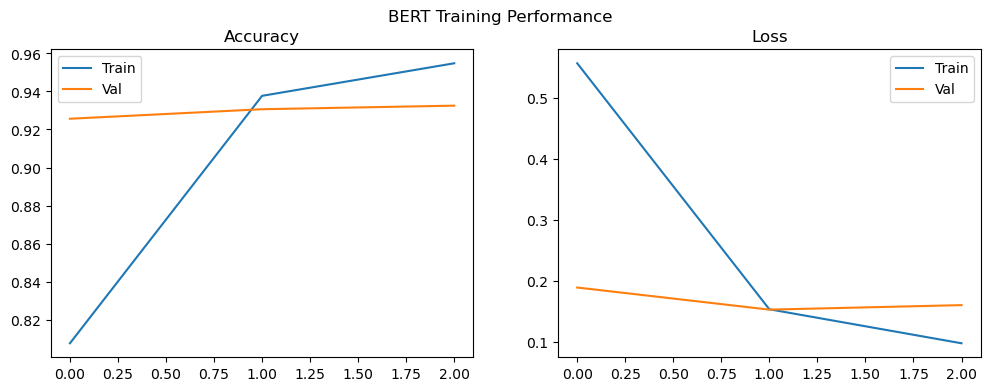

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
800/800 [==============================] - 1927s 2s/step - loss: 0.5372 - accuracy: 0.8144 - val_loss: 0.2082 - val_accuracy: 0.9209
Epoch 2/3
800/800 [==============================] - 1818s 2s/step - loss: 0.1476 - accuracy: 0.9404 - val_loss: 0.1619 - val_accuracy: 0.9259
Epoch 3/3
800/800 [==============================] - 1831s 2s/step - loss: 0.1058 - accuracy: 0.9537 - val_loss: 0.1644 - val_accuracy: 0.9278


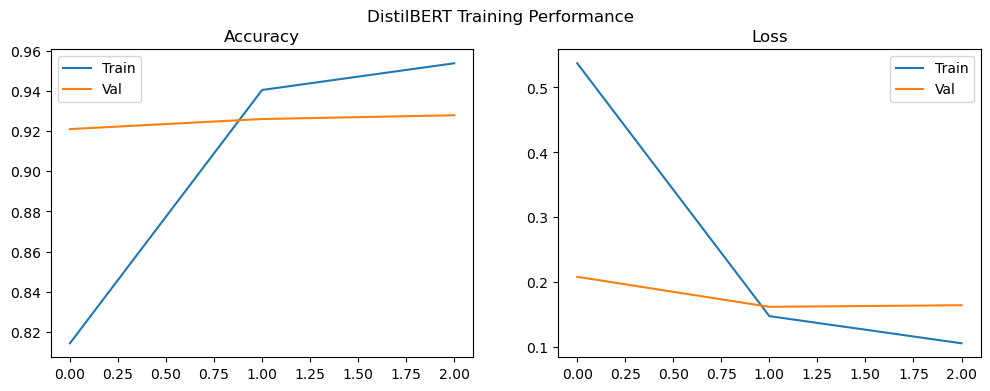

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Anacconda\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ssss\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
800/800 [==============================] - 3995s 5s/step - loss: 0.5348 - accuracy: 0.8129 - val_loss: 0.2127 - val_accuracy: 0.9187
Epoch 2/3
800/800 [==============================] - 3803s 5s/step - loss: 0.1794 - accuracy: 0.9284 - val_loss: 0.1704 - val_accuracy: 0.9278
Epoch 3/3
800/800 [==============================] - 3797s 5s/step - loss: 0.1272 - accuracy: 0.9401 - val_loss: 0.1493 - val_accuracy: 0.9306


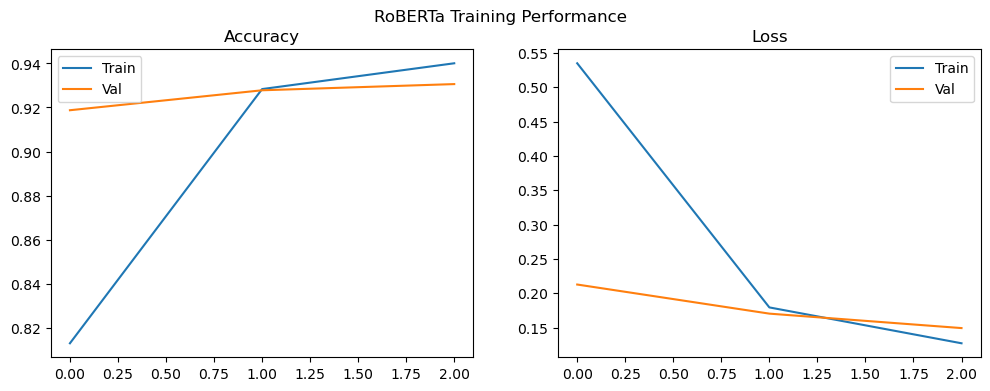

In [9]:
from transformers import (
    AutoTokenizer, TFAutoModelForSequenceClassification,
    DataCollatorWithPadding, create_optimizer
)
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt

df_train['label'] = le.transform(df_train['emotion'])  # already encoded above

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_train['text'], df_train['label'], test_size=0.2, stratify=df_train['label'], random_state=42
)

train_ds = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_ds = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

models = {
    "BERT": "bert-base-uncased",
    "DistilBERT": "distilbert-base-uncased",
    "RoBERTa": "roberta-base"
}

results = {}

for model_name, model_checkpoint in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    def tokenize_function(example): return tokenizer(example["text"], truncation=True)
    tokenized_train = train_ds.map(tokenize_function, batched=True)
    tokenized_test = test_ds.map(tokenize_function, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(le.classes_))

    optimizer, _ = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=len(tokenized_train))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    history = model.fit(
        tokenized_train.to_tf_dataset(columns=["input_ids", "attention_mask"], label_cols="label", batch_size=16, collate_fn=data_collator),
        validation_data=tokenized_test.to_tf_dataset(columns=["input_ids", "attention_mask"], label_cols="label", batch_size=16, collate_fn=data_collator),
        epochs=3
    )

    # Save final accuracy
    results[model_name] = history.history['val_accuracy'][-1]

    # Plot learning curves
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{model_name} Training Performance')
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss'); plt.legend()
    plt.show()

#### 6.	Check for overfitting and underfitting

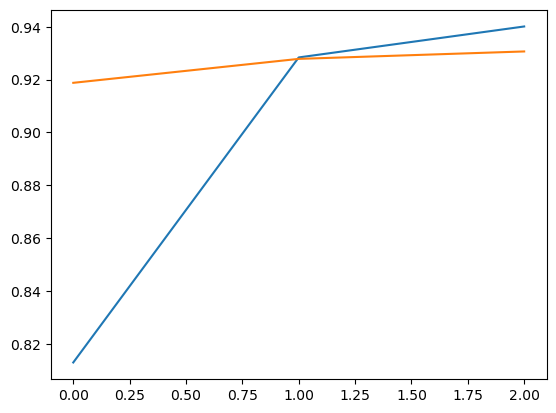

In [11]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')

In [12]:
print("Final Train Accuracy: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Final Val Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))

Final Train Accuracy: 94.01%
Final Val Accuracy: 93.06%


##### If Train accuracy ↑ and Val accuracy ↓, it's overfitting - Its Not Overfitting.
##### If both are low, it's underfitting - Is not undrfitting.
##### If both are high and close, it's a good fit - Since both are high and close, Itz Good Model.

#### 7. Finally create a table to compare the performances of all the models and suggest the best model.

In [10]:
comparison_df = pd.DataFrame([
    ["Simple BiLSTM", history.history['val_accuracy'][-1]],
    *[[name, acc] for name, acc in results.items()]
], columns=["Model", "Validation Accuracy"])

print(comparison_df.sort_values(by="Validation Accuracy", ascending=False))

           Model  Validation Accuracy
1           BERT             0.932500
0  Simple BiLSTM             0.930625
3        RoBERTa             0.930625
2     DistilBERT             0.927813
